<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/06_Genomics/Predicting_TF_binding_chromatin_accessibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem - Prediction transcription factor (TF) binding**: TFs are proteins that bind to DNA. When they bind, they influence the probability of nearby genes being transcribed into RNA.

But how does a TF know where to bind?

**Aproach in this project - A convolutional model**:
* Particular TF JUND.
* Particular kind of cell called HepG2.
* Only data from chromosome 22 (50 million bases long).
* The full chromosome has been split up into short segments (101 bases long) and each segment has been labeled to indicate whether it does or does not include a site where JUND binds.

The only input it looks at is the DNA sequence, and TF binding also depends on lots of other factors: accessibility, methylation, shape, the presence of other molecules, etc. So, in this model we also feed it with data chromatin accessibility.

The name chromatin refers to everything that makes up a chromosome: DNA, histones, and various other proteins and RNA molecules. *Chromatin accessibility* refers to how accessible each part of the chromosome is to outside molecules.

Instead of thinking of accessibility as a binary choice (accessible or inaccessible), it is better to think of it as a continuous variable (what fraction of the time each region is accessible).

Note: If you want to train the model, you should enable GPU. Also, if you want to train the model several times, it's better to move the data to your Google Drive and load from it.

## Setup

In [ ]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

## Load data

### Chromatin accessibility

In [ ]:
# Getting data of chromatin accessibility
import requests

data_url = 'https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter06/accessibility.txt'
req = requests.get(data_url)
text = req.text

span_accessibility = {}
for line in text.splitlines():
  fields = line.split()
  span_accessibility[fields[0]] = float(fields[1])

In [ ]:
print("Size: ", len(span_accessibility))

cont = 0
for key, value in span_accessibility.items():
  print(key, value)
  cont += 1

  if cont > 5:
    break
    
print("."*3)

Size:  345271
chr22:20208963-20209064 0.003902
chr22:29673572-29673673 0.004378
chr22:28193720-28193821 0.001946
chr22:43864274-43864375 0.003869
chr22:18261550-18261651 0.003066
chr22:49798024-49798125 0.003794


### Dataset - DNA (chromosome 22)

In [ ]:
# Create directories to load datasets (after running, please check 'folder' on the left side)
!mkdir 'tfbinding'
%cd 'tfbinding/'
!mkdir 'train_dataset'
!mkdir 'valid_dataset'

/content/tfbinding


IMPORTANT TO DO:
1. Download [train_set](https://downgit.github.io/#/home?url=https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter06/train_dataset),
2. Download [valid_set](https://downgit.github.io/#/home?url=https://github.com/deepchem/DeepLearningLifeSciences/tree/master/Chapter06/valid_dataset),
3. Upload files into `tfbinding/` into corresponding dataset.
4. Wait until all files are loaded.

In [ ]:
# Load data using DiskDataset
train = dc.data.DiskDataset('train_dataset')
valid = dc.data.DiskDataset('valid_dataset')

In [ ]:
print('Train shape: {}'.format(train.get_data_shape))
print('Valid shape: {}'.format(valid.get_data_shape))

Train shape: <bound method DiskDataset.get_data_shape of <DiskDataset X.shape: (276216, 101, 4), y.shape: (276216, 1), w.shape: (276216, 1), task_names: [0]>>
Valid shape: <bound method DiskDataset.get_data_shape of <DiskDataset X.shape: (34527, 101, 4), y.shape: (34527, 1), w.shape: (34527, 1), task_names: [0]>>


## Creating the model (CNN - 1D)


In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [ ]:
segment_length = 101
num_bases = 4
batch_size = 1000

input_shape = (segment_length, num_bases)

In [ ]:
# Creating the Keras model

accessibility = tf.keras.Input(shape=(1,))
dna_input = tf.keras.Input(shape=input_shape)

cnn = dna_input

for _ in range(3):
  cnn = layers.Conv1D(filters=15, kernel_size=10, activation='relu', padding='same')(cnn)
  cnn = layers.Dropout(rate=0.5)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Concatenate()([cnn, accessibility])

logits = layers.Dense(units=1)(cnn)
output = layers.Activation('sigmoid')(logits)

keras_model = tf.keras.Model(inputs=[dna_input, accessibility], outputs=[output, logits])

keras_model.summary()
print(type(keras_model).__name__)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 101, 15)      615         input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 101, 15)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 101, 15)      2265        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Creating Deep Chem model
model = dc.models.KerasModel(
  model=keras_model, 
  loss=dc.models.losses.SigmoidCrossEntropy(),
  output_types=['prediction', 'loss'],
  batch_size=batch_size
)

Given that our model has two different feature (input) layer, so we need a custom function to generate batches. 

In [ ]:
import numpy as np

In [ ]:
def generate_batches(dataset, epochs):
  for epoch in range(epochs):
    for X, y, w, ids in dataset.iterbatches(batch_size=batch_size, pad_batches=True):
      
      yield([X, np.array([span_accessibility[id] for id in ids])], [y], [w])

## Training

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
num_epochs = 6

# Test performance in training and validation dataset
train_roc_auc_scores = []
valid_roc_auc_scores = []

# 60 epochs in total

for i in range(10):
  model.fit_generator(generate_batches(train, epochs=num_epochs))

  print("Epoch {}/{}".format((i + 1) * num_epochs, 10 * num_epochs))

  train_score = model.evaluate_generator(generate_batches(train, 1), [metric])
  print('TRAIN: ', train_score)

  valid_score = model.evaluate_generator(generate_batches(valid, 1), [metric])
  print('VALIDATION: ', valid_score, '\n')

  train_roc_auc_scores.append(train_score['roc_auc_score'])
  valid_roc_auc_scores.append(valid_score['roc_auc_score'])

In [ ]:
print(train_roc_auc_scores[-1])
print(valid_roc_auc_scores[-1])

0.8411469483233087
0.7601419645699499


## Performance

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

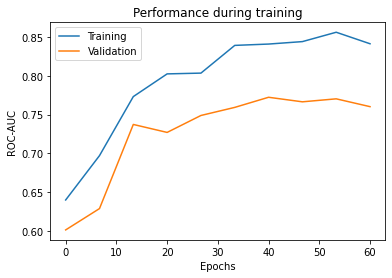

In [ ]:
x = np.linspace(0, num_epochs * 10, 10)

plt.title('Performance during training')
plt.plot(x, train_roc_auc_scores, label='Training')
plt.plot(x, valid_roc_auc_scores, label='Validation')

plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')

plt.legend()
plt.show()